In [1]:
%matplotlib widget

# DEFAULTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson


FORCES=["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF=[400,450,500,550]

plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker":"d", "markevery": 10, "markersize": 3, "color": "tab:orange"},
               "NLO": {"marker":".", "markevery": 10, "color": "tab:blue"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "tab:green"},
               "N3LO": {"ls": "dotted", "color": "tab:red"},
               "N4LO": {"color": "black"},
               "N4LO+": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "tab:cyan"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "tab:pink"},
               "SIEGERT": {"color": "tab:blue"},
               "1NC": {"color": "tab:pink", "ls": "dashed"}
              }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"], 
            }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor":"None", "markeredgecolor": "k"},
    {"fmt": "s", "color": "darkred"},
    {"fmt": "^", "color": "olive"},
    {"fmt": "X", "color": "darkcyan"},
    {"fmt": "d", "color": "magenta"},
]

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}



df_my = pd.read_csv("Deuteron/deuteron_all_data.csv")
# df_my.T21D2 *= 2
# df_my.T22D2 *= 2
df_exp = pd.read_csv("./Deuteron/deuteron_exp_diffcross.csv")
df_exp_tot = pd.read_csv("./Deuteron/deuteron_exp_totcross.csv")

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in ["THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()
my_energies


rachek_bins = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                             names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                   "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                   "T22", "T22stater", "T22syser"])


# Rest

In [3]:
print(OBSERVABLES)

['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']


# Cross section

## Differential Cross Section

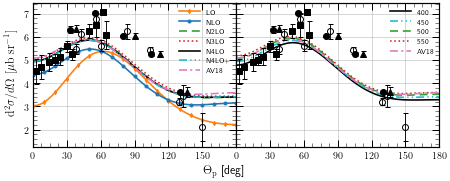

In [47]:
obs="CROSS2"
ylabel="$\mathrm{d}^2\sigma / d \Omega ~[\mu\mathrm{b~sr}^{-1}]$"
energy=100

# fig, axes = plt.subplots(1,2, figsize=(6.5, 2.8))
fig = plt.figure(figsize=(6.5, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)
fig.supylabel(ylabel, x=0.03, y=0.6, size=12)
for force in FORCES:
    df_tmp = df_my[(df_my.FORCE == force) & (df_my.CUTOFF == 450) & (df_my.Energy == energy) & (df_my.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                 **line_styles[force], label = force)
for cutoff in CUTOFF:
    df_tmp = df_my[(df_my.FORCE == "N4LO+") & (df_my.CUTOFF == cutoff) & (df_my.Energy == energy) & (df_my.WAVE == "SIEGERT")]
    axes[1].plot(df_tmp.angle, df_tmp[obs],
                 **ls_cutoff[cutoff], label = cutoff)
df_av18 = df_my[(df_my.FORCE == "AV18") & (df_my.Energy == energy)]
for j,ax in enumerate(axes):
    ax.plot(df_av18.angle, df_av18[obs],
                 **line_styles["AV18"], label = "AV18")
    for i, fname in enumerate(df_exp[df_exp.energy == energy].fname.unique()):
        df_tmp = df_exp[(df_exp.energy == energy) & (df_exp.fname == fname)]
        ax.errorbar(df_tmp.angle, df_tmp.CROSS,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common)
    # style
    ax.legend(fontsize=7, handlelength=3)
    ax.tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0,180])
    ax.grid()
fig.tight_layout()
# plt.savefig(f"Figures_python/{obs}_{energy}mev.pdf", dpi=600, facecolor="white")
plt.show()


## Total Cross Section

In [333]:
CROSS_TOT = []
CROSS_TOT_1nc = []
for energy in tqdm(my_energies):
    df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.CUTOFF == 450) &
                (df_my.Energy == energy) &
                (df_my.WAVE == "SIEGERT")]
    x = df_tmp.THCM.values
    y = df_tmp.CROSS2.values*np.sin(x)
    CROSS_TOT.append(2*np.pi*simpson(y,x=x))
    df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.CUTOFF == 450) &
                (df_my.Energy == energy) &
                (df_my.WAVE == "1NC")]
    x = df_tmp.THCM.values
    y = df_tmp.CROSS2.values*np.sin(x)
    CROSS_TOT_1nc.append(2*np.pi*simpson(y,x=x))
CROSS_TOT = np.array(CROSS_TOT)
CROSS_TOT_1nc = np.array(CROSS_TOT_1nc)
CROSS_TOT = np.nan_to_num(CROSS_TOT)
CROSS_TOT_1nc = np.nan_to_num(CROSS_TOT_1nc)

100%|██████████| 49/49 [00:02<00:00, 21.37it/s]


In [334]:
df_exp_tot.fillna(0, inplace=True)

Bernabei  ->  {'fmt': 'ok'}
Bosman  ->  {'fmt': 'ok', 'markerfacecolor': 'None', 'markeredgecolor': 'k'}
arends  ->  {'fmt': 's', 'color': 'darkred'}
Skopik  ->  {'fmt': '^', 'color': 'olive'}
Moreh  ->  {'fmt': 'X', 'color': 'darkcyan'}
Birenbaum  ->  {'fmt': 'd', 'color': 'magenta'}


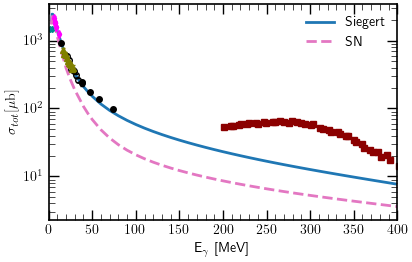

In [335]:
plt.figure(figsize=(4.5,2.8))
# plt.figure(figsize=(6,4))
# plt.figure(figsize=(6.5, 2.8))
plt.plot(my_energies, CROSS_TOT, label="Siegert", **line_styles["SIEGERT"])
plt.plot(my_energies, CROSS_TOT_1nc, label="SN", **line_styles["1NC"])
marker_common_tmp = {"markersize": 4, "elinewidth": 0.4, "capsize": 1.5}
for i, fname in enumerate(df_exp_tot.fname.unique()):
    df_tmp = df_exp_tot[df_exp_tot.fname == fname]
    plt.errorbar(df_tmp.E, df_tmp.TOTCROSS, yerr=df_tmp.ERR,
                #  label=fname.split(".")[0].replace("data_arends1984", "arends"),
                 **exp_style[i], **marker_common_tmp)
    print(fname.split(".")[0].replace("data_arends1984", "arends"), " -> ", exp_style[i])
# plt.legend(fontsize=7, handlelength=3)
plt.tick_params(which='minor', direction='in', length=4,
               width=0.5, top=True, right=True)
plt.tick_params(which='major', direction='in',
            length=7, width=1, top=True, right=True)

plt.yscale("log")
# plt.xscale("log")
plt.ylabel("$\sigma_{tot}[\mu \mathrm{b}]$")
plt.xlabel("E$_\gamma$ [MeV]")
plt.legend()


plt.xlim([0,400])
# plt.grid(which='both', alpha=0.5)
plt.savefig(f"Figures_python/TOTAL_CROSSSECTION.pdf", dpi=600, facecolor="white")
plt.show()


# Tensor analyzing power

## Energy distribution

In [3]:
df_raczek_T20_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/raczek_mishev_T20_88.csv",
                                header=None, skiprows=2,
                                names=["raczek_X", "raczek_Y",
                                        "raczek_errX", "raczek_errY",
                                        "mishev_X", "mishev_Y",
                                        "mishev_errX", "mishev_errY"])
df_raczek_T20_88["raczek_err"] = df_raczek_T20_88["raczek_errY"] - \
    df_raczek_T20_88["raczek_Y"]
df_raczek_T20_88["mishev_err"] = df_raczek_T20_88["mishev_errY"] - \
    df_raczek_T20_88["mishev_Y"]

df_arenh_T20_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/arenhovel_T20.csv",
                                header=None, names=["energy", "T20"])

df_raczek_T22_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/raczek_mishev_T22_88.csv",
                                header=None, skiprows=2,
                                names=["raczek_X", "raczek_Y",
                                        "raczek_errX", "raczek_errY",
                                        "mishev_X", "mishev_Y",
                                        "mishev_errX", "mishev_errY"])
df_raczek_T22_88["raczek_err"] = df_raczek_T22_88["raczek_errY"] - \
    df_raczek_T22_88["raczek_Y"]
df_raczek_T22_88["mishev_err"] = df_raczek_T22_88["mishev_errY"] - \
    df_raczek_T22_88["mishev_Y"]

df_arenh_T22_88 = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/arenhovel_T22.csv",
                                header=None, names=["energy", "T22"])



In [4]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                # (df_my.CUTOFF == 450) &
                (df_my.angle == 88) &
                (df_my.WAVE == "SIEGERT")]
df_tmp = df_tmp.sort_values("Energy")

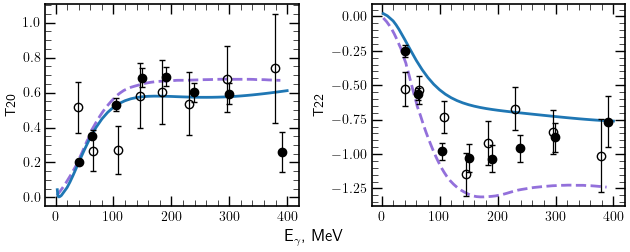

In [6]:
fig, ax = plt.subplots(1,2, figsize=(6.5, 2.8))
fig.supxlabel("E$_\gamma$, MeV", y=0.08, size=12)

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 400].Energy,
#            df_tmp[df_tmp.CUTOFF == 400].T20D2,
#            label="N4LO+ 400", zorder=2, lw=2)

ax[0].plot(df_tmp[df_tmp.CUTOFF == 450].Energy,
           df_tmp[df_tmp.CUTOFF == 450].T20D2,
           label="N4LO+ 450", zorder=2, lw=2, **line_styles["SIEGERT"])

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 500].Energy,
#            df_tmp[df_tmp.CUTOFF == 500].T20D2,
#            label="N4LO+ 500", zorder=2, lw=2)

# ax[0].plot(df_tmp[df_tmp.CUTOFF == 550].Energy,
#            df_tmp[df_tmp.CUTOFF == 550].T20D2,
#            label="N4LO+ 550", zorder=2, lw=2)
ax[0].plot(df_arenh_T20_88.energy, df_arenh_T20_88.T20, label="arenhovel",
           ls="dashed", zorder=1, lw=2, color="mediumpurple")
ax[0].errorbar(df_raczek_T20_88.raczek_X, df_raczek_T20_88.raczek_Y, yerr=df_raczek_T20_88.raczek_err,
               zorder=3, label="Rachek et al", **exp_style[0], **marker_common)
ax[0].errorbar(df_raczek_T20_88.mishev_X, df_raczek_T20_88.mishev_Y, yerr=df_raczek_T20_88.mishev_err,
               zorder=3, label="Mishev et al", **exp_style[1], **marker_common)
# ax[0].legend(fontsize=6)
ax[0].tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
ax[0].tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
ax[0].set_ylabel("T20")

ax[1].plot(df_tmp[df_tmp.CUTOFF == 450].Energy,
           df_tmp[df_tmp.CUTOFF == 450].T22D2,
           label="N4LO+",
           zorder=2, lw=2, **line_styles["SIEGERT"])
ax[1].plot(df_arenh_T22_88.energy, df_arenh_T22_88.T22,
           label="arenhovel", ls="dashed", zorder=1,
           lw=2, color="mediumpurple")
ax[1].errorbar(df_raczek_T22_88.raczek_X, df_raczek_T22_88.raczek_Y, yerr=df_raczek_T22_88.raczek_err,
               zorder=3, label="Rachek et al", **exp_style[0], **marker_common)
ax[1].errorbar(df_raczek_T22_88.mishev_X, df_raczek_T22_88.mishev_Y, yerr=df_raczek_T22_88.mishev_err,
               zorder=3, label="Mishev et al", **exp_style[1], **marker_common)
# ax[1].legend(fontsize=6)
ax[1].tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
ax[1].tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
ax[1].set_ylabel("T22", x=20)
# plt.ylabel(

fig.tight_layout()
plt.savefig(f"Figures_python/T20_T22_vs_en.pdf", dpi=600, facecolor="white")
plt.show()


## Angular distribution

In [7]:
rachek_angular = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_theta.txt", delim_whitespace=True,
                             names=["Emin", "Emax", "Emean", "THmin", "THmax", "THmean",
                                   "T20", "T20stater", "T20syser", "T21", "T21stater", "T21syser",
                                   "T22", "T22stater", "T22syser"])
rachek_angular["THerr"] = rachek_angular.THmean - rachek_angular.THmin

In [8]:
espans = list(map(lambda x: list(map(lambda x: int(float(x)), x.split())), (rachek_angular.Emin.astype(str) + " " + rachek_angular.Emax.astype(str)).unique()))

In [9]:
print(espans)

[[25, 45], [45, 70], [70, 100], [100, 140], [140, 180], [180, 230], [230, 330], [330, 440]]


In [10]:
for espan in tqdm(espans):
    df_sieg = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.Energy >=espan[0]) &
                    (df_my.Energy <= espan[1]) &
                    (df_my.WAVE == "SIEGERT")]
    df_1nc = df_my[(df_my.FORCE == "N4LO+") &
                        (df_my.CUTOFF == 450) &
                        (df_my.Energy >=espan[0]) &
                        (df_my.Energy <= espan[1]) &
                        (df_my.WAVE == "1NC")]
    df_exp = rachek_angular[(rachek_angular.Emin==espan[0]) & (rachek_angular.Emax==espan[1])]
    fig, ax = plt.subplots(1,3, figsize=(9, 2.8))
    fig.suptitle("E$_\gamma$ = {} - {} MeV".format(*espan))
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.08, size=12)

    for i, obs in enumerate(["T20", "T21", "T22"]):

        # Siegert
        df_gr = df_sieg.groupby("angle")[obs+"D2"].agg(['min', 'max', 'mean']).reset_index()
        ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr,
                        zorder=3, alpha=0.5, **line_styles["SIEGERT"])
        ax[i].plot(df_gr.angle, df_gr["mean"],
                   zorder=3, label="Siegert", **line_styles["SIEGERT"])
        # SN current
        df_gr_1nc = df_1nc.groupby("angle")[obs+"D2"].agg(['min', 'max', 'mean']).reset_index()
        ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr_1nc,
                           zorder=2, alpha=0.5,
                           **line_styles["1NC"])
        ax[i].plot(df_gr_1nc.angle, df_gr_1nc["mean"],
                   zorder=2, label="SN", **line_styles["1NC"])
        # experiment
        ax[i].errorbar(x="THmean", y=obs, yerr=obs + "stater", data=df_exp,
                       zorder=4, label=None, **exp_style[0], **marker_common)

        # style
        ax[i].axhline(c="k", zorder=1, lw=1.2)
        ax[i].set_ylabel(obs)
        # ax[i].yaxis.set_label_coords(-0.15, 0.5)
        ax[i].tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
        ax[i].tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
    ax[1].legend(fontsize=8)
    fig.tight_layout()
    # break
    plt.savefig("Figures_python/Tensor_analyzing_power_angular_E{}-{}.pdf".format(*espan), dpi=600, facecolor="white")
    # plt.show()
    plt.close()

100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


## Integrated

In [11]:
from copy import deepcopy

rachek_integr = pd.read_csv("Deuteron/ExpData/TensoeAnalyzingPower/rachek_t2i_vs_egamma.txt",
                            delim_whitespace=True,
                            names=['E-gamma_start', 'E-gamma_end', 'E-gamma_mean', 'Theta-p_start',
                                   'Theta-p_end', 'Theta-p_mean', 'T20_value', 'T20_stat_err',
                                   'T20_sys_err', 'T21_value', 'T21_stat_err', 'T21_sys_err',
                                   'T22_value', 'T22_stat_err', 'T22_sys_err'])
rachek_integr = rachek_integr[rachek_integr["E-gamma_start"] < 400]
Eerr=np.array(list(zip(rachek_integr["E-gamma_mean"]-rachek_integr["E-gamma_start"],
                       rachek_integr["E-gamma_end"]-rachek_integr["E-gamma_mean"])))

In [13]:
# angles = (24, 48)
angles = (70, 102)
data={
    "SIEGERT": {
        "min": [],
        "max": [],
        "mean": []
    },
    "1NC": {
        "min": [],
        "max": [],
        "mean": []
    }
}
data_all={}
for i in range(3):
    obs = f"T2{i}"
    data_all[obs] = deepcopy(data)
    
    df_local = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.angle >= angles[0]) &
                    (df_my.angle <= angles[1])]
    for energy in tqdm(my_energies, desc=obs):
        for wave in ["1NC", "SIEGERT"]:
            df_tmp = df_local[
                (df_local.Energy == energy) &
                (df_local.WAVE == wave)
            ]
            x = df_tmp.THCM.values
            y = df_tmp[obs + "D2"].values
            mean = np.mean(y)
            # std = np.std(y)
            data_all[obs][wave]["mean"].append(mean)
            data_all[obs][wave]["min"].append(np.min(y))
            data_all[obs][wave]["max"].append(np.max(y))

T22: 100%|██████████| 49/49 [00:00<00:00, 279.16it/s]


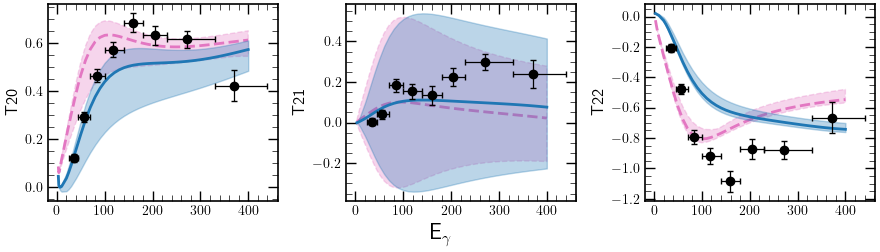

In [15]:
fig, ax = plt.subplots(1,3, figsize=(9, 2.8))
fig.supxlabel("E$_\gamma$", y=0.08, size=16)
for i in range(3):
    obs = f"T2{i}"
    for num, current_type in enumerate(["1NC", "SIEGERT"]):
        ax[i].fill_between(my_energies, data_all[obs][current_type]["min"],
                           data_all[obs][current_type]["max"],
                           alpha=0.3, zorder=2+num,
                           **line_styles[current_type])
        ax[i].plot(my_energies, data_all[obs][current_type]["mean"],
                   zorder=2+num, **line_styles[current_type])

    ax[i].errorbar(x="E-gamma_mean", y=f"{obs}_value", yerr=f"{obs}_stat_err",
                   xerr=Eerr[np.where((rachek_integr["Theta-p_start"]>=angles[0]) &
                                      (rachek_integr["Theta-p_end"]<=angles[1]))].T,
                   data=rachek_integr[(rachek_integr["Theta-p_start"]>=angles[0]) &
                                    (rachek_integr["Theta-p_end"]<=angles[1])],
                   zorder=4, **exp_style[0], **marker_common)
    ax[i].tick_params(which='minor', direction='in', length=4, width=0.5, top=True, right=True)
    ax[i].tick_params(which='major', direction='in', length=7, width=1, top=True, right=True)
#     ax[i].grid(zorder=1)
#     ax[i].axhline(c="k", zorder=1, lw=1.2)
    ax[i].set_ylabel(obs, size=12)
    # ax[i].set_xlim([0,200])
fig.tight_layout()
plt.savefig("Figures_python/TensorPower_Th{}-{}.pdf".format(*angles), dpi=600, facecolor="white")
plt.show()


### Test

In [235]:
dfr_tmp = rachek_integr[(rachek_integr["Theta-p_start"]>=angles[0]) &
                                    (rachek_integr["Theta-p_end"]<=angles[1])]

In [243]:
df_tmp = df_local[df_local.WAVE == "SIEGERT"]
ener = []
t21 = []
for ang, en in dfr_tmp[["Theta-p_mean", "E-gamma_mean"]].values:
    # print(en, ang)
    Eclose = df_tmp.iloc[(df_tmp['Energy']-en).abs().argsort()[:1]].Energy
    # print(Eclose)
    ener.append(Eclose.values[0])
    df_tmp2 = df_tmp[df_tmp.Energy == Eclose.values[0]]
    val = df_tmp2.iloc[(df_tmp2['angle']-ang).abs().argsort()[:1]].T22D2.values[0]
    print(df_tmp2.iloc[(df_tmp2['angle']-ang).abs().argsort()[:1]].angle)
    t21.append(val)


11620    36.0
Name: angle, dtype: float64
14334    35.0
Name: angle, dtype: float64
16325    35.0
Name: angle, dtype: float64
23383    34.0
Name: angle, dtype: float64
10893    33.0
Name: angle, dtype: float64
15780    33.0
Name: angle, dtype: float64
5281    32.0
Name: angle, dtype: float64
23018    31.0
Name: angle, dtype: float64


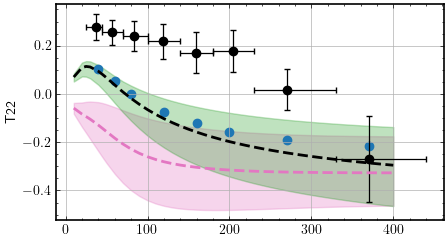

In [244]:
plt.figure(figsize=(5, 2.8))
obs = "T22"
plt.fill_between(my_energies, data_all[obs]["1NC"]["min"],
                data_all[obs]["1NC"]["max"],
                alpha=0.3, color="tab:pink", zorder=1)
plt.plot(my_energies, data_all[obs]["1NC"]["mean"],
        color="tab:pink", ls="dashed",  zorder=2)

plt.fill_between(my_energies, data_all[obs]["SIEGERT"]["min"],
                data_all[obs]["SIEGERT"]["max"],
                alpha=0.3, color="tab:green", zorder=1)
plt.plot(my_energies, data_all[obs]["SIEGERT"]["mean"],
        color="k", ls="dashed",  zorder=2)

plt.errorbar(x="E-gamma_mean", y=f"{obs}_value", yerr=f"{obs}_stat_err",
                xerr=Eerr[np.where((rachek_integr["Theta-p_start"]>=angles[0]) &
                                    (rachek_integr["Theta-p_end"]<=angles[1]))].T,
                data=rachek_integr[(rachek_integr["Theta-p_start"]>=angles[0]) &
                                    (rachek_integr["Theta-p_end"]<=angles[1])], zorder=2,
                **exp_style[0], **marker_common)
plt.scatter(ener, t21, c="tab:blue")
plt.grid()
plt.ylabel(obs)
plt.show()

### Derivative

In [261]:
df_sieg = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.Energy == 20) &
                    (df_my.WAVE == "SIEGERT")]
df_1nc = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.Energy == 20) &
                    (df_my.WAVE == "1NC")]
# df_1nc = df_my[(df_my.FORCE == "N4LO+") &
#                     (df_my.CUTOFF == 450) &
#                     (df_my.Energy >=espan[0]) &
#                     (df_my.Energy <= espan[1]) &
#                     (df_my.WAVE == "1NC")]
# df_exp = rachek_angular[(rachek_angular.Emin==espan[0]) & (rachek_angular.Emax==espan[1])]

# df_gr = df_sieg.groupby("angle")[obs+"D2"].agg(['min', 'max', 'mean']).reset_index()
    # ax[i].fill_between(x="angle", y1="min", y2="max", data=df_gr,
    #                 zorder=3, alpha=0.5, **line_styles["SIEGERT"])
    # ax[i].plot(df_gr.angle, df_gr["mean"],
    #                zorder=3, label="Siegert", **line_styles["SIEGERT"])

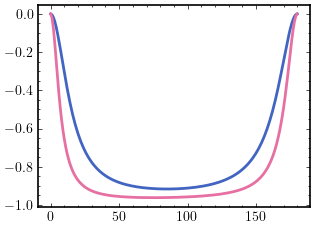

In [262]:
plt.figure()
plt.plot(df_sieg.angle, df_sieg["AX2"])
plt.plot(df_1nc.angle, df_1nc["AX2"])
plt.show()

In [255]:
print(OBSERVABLES)

['CROSS', 'CROSS2', 'P1', 'P2', 'PHIP', 'WAVE', 'T11D', 'T20D', 'T21D', 'T22D', 'T11D2', 'T20D2', 'T21D2', 'T22D2', 'AX', 'AY', 'AZ', 'AX2', 'AY2', 'AZ2', 'POLNOUT(y)', 'POLNOUT2(y)', 'CROSSCAP', 'CROSSCAP2', 'AYN1CAP', 'AYN1CAP2', 'Energy']
